# Basic usage of modified transformers library (modification have been done only for BERT)

## Install the changed library (only first once)

1. move into the modified library
> $ cd transformers

1. install using pip (I recommend editable mode (-e option).)
> $ pip install -e .

1. please install pytorch (https://pytorch.org/) \
 e.g., 
 > $ pip install torch torchvision

## Usage

In [1]:
import torch
from transformers import BertModel, BertTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2182,  2003,  2070,  3793,  2000,  4372, 16044,   102]],
       device='cuda:0')
['[CLS]', 'here', 'is', 'some', 'text', 'to', 'en', '##code', '[SEP]']


In [3]:
# If you want to extract vector norms (i.e., ||f(x)||, ||αf(x)||, ||Σαf(x)||), please set the argument "output_norms" to True.
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [4]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [5]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [6]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 9])


In [7]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 9, 9])


In [8]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 9, 9])


## Comparison with attention weight

In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 7
head = 5

### Attention weight visualization (Head-level visualization)

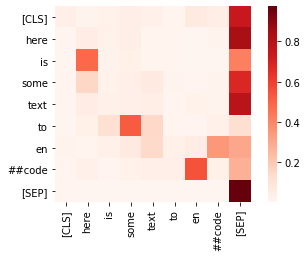

In [10]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

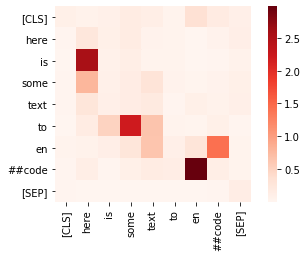

In [11]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention weight visualization (Layer-level visualization)

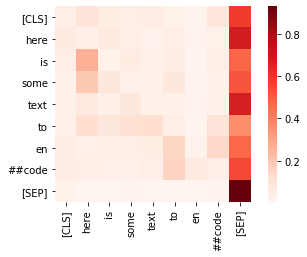

In [12]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

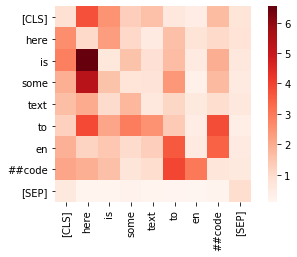

In [13]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)